# 1.0 Import

In [1]:
#Load and edit dataframe
import numpy as np
import pandas as pd


# Data Visualization
import seaborn           as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Select Train and Test
from sklearn.model_selection import train_test_split

# ML - Algoritms
from sklearn.preprocessing   import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

import warnings 
warnings.filterwarnings( 'ignore' ) 

## Load DataSet

In [2]:
df = pd.read_csv('../data/all_b3_bovespa.csv')

# Data Analysis


In [8]:
print(f'nº of columns: {df.shape[0]}, nº of rows:{df.shape[1]}')

nº of columns: 733407, nº of rows:10


In [9]:
df.dtypes

data_pregao          object
codbdi              float64
sigla_acao           object
nome_acao            object
preco_abertura      float64
preco_maximo        float64
preco_minimo        float64
preco_fechamento    float64
qtd_negocios          int64
volume_negocios       int64
dtype: object

In [10]:
a = df[df['nome_acao']=='PETROBRAS']
a

,data_pregao,codbdi,sigla_acao,nome_acao,preco_abertura,preco_maximo,preco_minimo,preco_fechamento,qtd_negocios,volume_negocios
212,2015-01-02,2.0,PETR3,PETROBRAS,9.58,9.67,9.00,9.00,12710900,1
213,2015-01-02,2.0,PETR4,PETROBRAS,9.99,9.99,9.36,9.36,48837200,4
529,2015-01-05,2.0,PETR3,PETROBRAS,8.64,8.96,8.25,8.27,24992200,2
530,2015-01-05,2.0,PETR4,PETROBRAS,9.14,9.19,8.58,8.61,77077300,6
828,2015-01-06,2.0,PETR3,PETROBRAS,8.28,8.53,7.78,8.06,29572100,2
...,...,...,...,...,...,...,...,...,...,...
733144,2021-12-23,2.0,PETR3,PETROBRAS,30.35,30.68,30.18,30.44,6243500,1
733145,2021-12-27,2.0,PETR3,PETROBRAS,30.44,31.23,30.24,31.04,17868100,5
733146,2021-12-28,2.0,PETR3,PETROBRAS,31.26,31.47,31.00,31.06,8078000,2
733147,2021-12-29,2.0,PETR3,PETROBRAS,31.01,31.34,30.75,30.95,11460950,3


# Data transformation

In [184]:
df_petro = df.copy()

In [185]:
df_petro['data_pregao'] = pd.to_datetime(df_petro['data_pregao'], format='%Y-%m-%d')

In [186]:
df_petro.dtypes

data_pregao         datetime64[ns]
codbdi                     float64
sigla_acao                  object
nome_acao                   object
preco_abertura             float64
preco_maximo               float64
preco_minimo               float64
preco_fechamento           float64
qtd_negocios                 int64
volume_negocios              int64
dtype: object

# Select only one share to predict

In [187]:
# Filter share_data
df_petro = df[df['sigla_acao']=='PETR4']
print(f'nº of rows: {df_petro.shape[0]}, nº of columns:{df_petro.shape[1]}')

nº of rows: 1730, nº of columns:10


In [190]:
df_petro_cls = df_petro[['data_pregao', 'preco_fechamento']]
df_petro_cls.dtypes

data_pregao          object
preco_fechamento    float64
dtype: object

In [196]:
# set to index with date
df_petro_cls = df_petro_cls.set_index(pd.DatetimeIndex(df_petro_cls['data_pregao']))

In [197]:
df_petro_cls.tail()

,data_pregao,preco_fechamento
data_pregao,,
2021-12-23,2021-12-23,28.33
2021-12-27,2021-12-27,28.75
2021-12-28,2021-12-28,28.78
2021-12-29,2021-12-29,28.54
2021-12-30,2021-12-30,28.45


In [198]:
# drop column 'data_pregao'
df_petro_cls.drop(['data_pregao'], axis=1, inplace=True)

In [199]:
df_petro_cls.tail().reset_index()

,data_pregao,preco_fechamento
0,2021-12-23,28.33
1,2021-12-27,28.75
2,2021-12-28,28.78
3,2021-12-29,28.54
4,2021-12-30,28.45


In [200]:
df_petro_cls.dtypes

preco_fechamento    float64
dtype: object

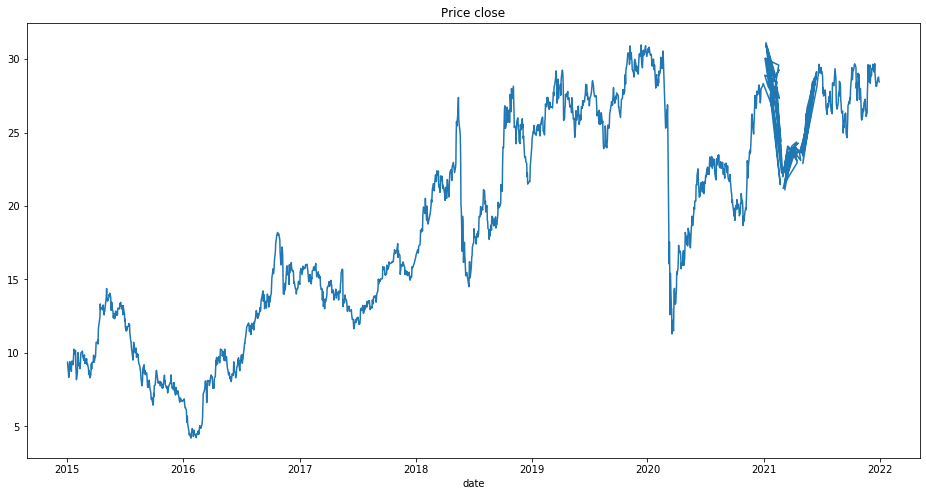

In [130]:
# Plot the dataframe
plt.figure(figsize=(16,8))
plt.title('Price close')
plt.plot(df_petro_cls['preco_fechamento'])
plt.xlabel('date');


# Data Train and Test

In [131]:
# Data analysis
qtt_rows = len(df_petro_cls)

r_train = round(.70*qtt_rows)

r_test = qtt_rows - r_train

info = (
    f'Train = 0:{r_train} | '
    f'Test = {r_train}:{r_train + r_test}'
    )
info

'Train = 0:1211 | Test = 1211:1730'

# Normalize and Reescale 

In [132]:
# Normalizing
std = StandardScaler()
df_scaled = std.fit_transform(df_petro_cls)

# Separating into Train and Test

In [133]:
train = df_scaled[:qtt_rows]

test = df_scaled[r_train: r_train+r_test]

print(len(train), len(test))

1730 519


In [134]:
# Convert an array of values into a df matrix

def create_df(df, steps=1):
    dataX, dataY = [], []
    for i in range(len(df)-steps-1):
        a = df[i:(i+steps), 0]
        dataX.append(a)
        dataY.append(df[i+steps,0])
    return np.array(dataX), np.array(dataY)

# dexa os valores formatados no padrão que o LSTM espera para aprender

In [135]:
# gerando os dados de treino e teste

steps = 15
X_train, Y_train = create_df(train, steps)
X_test, Y_test = create_df(test, steps)

In [136]:
print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)


(1714, 15)
(1714,)
(503, 15)
(503,)


In [137]:
# Gerando os dados no formato que o modelo espera
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_train.shape[0] → 1714 linhas de treino | X_train.shape[1] → 15 dias de treino
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [138]:
# Camadas da Rede Neural
model = Sequential()
model.add(LSTM(35, return_sequences=True, input_shape=(steps,1))) #1ª camada
#LSTM(35) → qtt de neuronios usados | input_shape=(steps,1) → qtt de dias a ser previsto e retornado
model.add(LSTM(35, return_sequences=True)) #2ª camada
model.add(LSTM(35)) #3ª camada
model.add(Dropout(0.2)) 
#Dropout evita o overfit do treinamento
model.add(Dense(1)) #retonrnando um unico resultado


In [139]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 15, 35)            5180      
                                                                 
 lstm_10 (LSTM)              (None, 15, 35)            9940      
                                                                 
 lstm_11 (LSTM)              (None, 35)                9940      
                                                                 
 dropout_3 (Dropout)         (None, 35)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 36        
                                                                 
Total params: 25,096
Trainable params: 25,096
Non-trainable params: 0
_________________________________________________________________


In [140]:
# treinamento do modelo
validation = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=15, verbose=2)

Epoch 1/100
115/115 - 8s - loss: 0.1398 - val_loss: 0.0819 - 8s/epoch - 70ms/step
Epoch 2/100
115/115 - 2s - loss: 0.0525 - val_loss: 0.0766 - 2s/epoch - 21ms/step
Epoch 3/100
115/115 - 2s - loss: 0.0442 - val_loss: 0.0490 - 2s/epoch - 21ms/step
Epoch 4/100
115/115 - 2s - loss: 0.0372 - val_loss: 0.0492 - 2s/epoch - 21ms/step
Epoch 5/100
115/115 - 2s - loss: 0.0349 - val_loss: 0.0509 - 2s/epoch - 20ms/step
Epoch 6/100
115/115 - 2s - loss: 0.0368 - val_loss: 0.0406 - 2s/epoch - 19ms/step
Epoch 7/100
115/115 - 2s - loss: 0.0306 - val_loss: 0.0375 - 2s/epoch - 21ms/step
Epoch 8/100
115/115 - 2s - loss: 0.0310 - val_loss: 0.0372 - 2s/epoch - 19ms/step
Epoch 9/100
115/115 - 2s - loss: 0.0283 - val_loss: 0.0369 - 2s/epoch - 20ms/step
Epoch 10/100
115/115 - 2s - loss: 0.0256 - val_loss: 0.0377 - 2s/epoch - 20ms/step
Epoch 11/100
115/115 - 2s - loss: 0.0276 - val_loss: 0.0330 - 2s/epoch - 21ms/step
Epoch 12/100
115/115 - 2s - loss: 0.0256 - val_loss: 0.0407 - 2s/epoch - 20ms/step
Epoch 13/100


Epoch 100/100
115/115 - 2s - loss: 0.0200 - val_loss: 0.0304 - 2s/epoch - 20ms/step


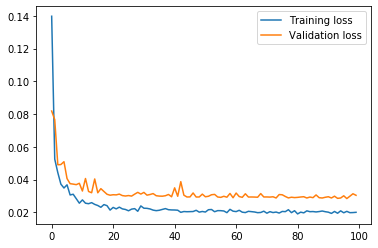

In [141]:
plt.plot(validation.history['loss'], label='Training loss')
plt.plot(validation.history['val_loss'], label='Validation loss')
plt.legend();

In [142]:
# Prediction
prev = model.predict(X_test)
prev = std.inverse_transform(prev)
prev

array([[30.298292],
       [30.23776 ],
       [30.326935],
       [30.393913],
       [30.386627],
       [30.453667],
       [30.58816 ],
       [30.602224],
       [30.552893],
       [30.628313],
       [30.602528],
       [30.677021],
       [30.693651],
       [30.673159],
       [30.634068],
       [30.569801],
       [30.533083],
       [30.420448],
       [30.227222],
       [30.069946],
       [30.028957],
       [30.029951],
       [29.945755],
       [29.81689 ],
       [29.808577],
       [29.706549],
       [29.271187],
       [29.206566],
       [29.11439 ],
       [29.107851],
       [28.960062],
       [28.788708],
       [28.81971 ],
       [28.74508 ],
       [28.983665],
       [29.044863],
       [29.186573],
       [29.379393],
       [29.691803],
       [29.794312],
       [29.807491],
       [29.786942],
       [29.861109],
       [30.100931],
       [30.099709],
       [29.92892 ],
       [28.871822],
       [27.525507],
       [26.46769 ],
       [26.412312],


In [143]:
# Predict the next 10 days
lenght_test = len(test)
lenght_test

519

In [144]:
# Get the last days to step
days_input_steps =lenght_test - steps
days_input_steps

504

In [145]:
# Transform in array
input_steps = test[days_input_steps:]
input_steps = np.array(input_steps).reshape(1, -1)
input_steps

array([[1.41048896, 1.4595649 , 1.43502693, 1.3873142 , 1.41185218,
        1.46501778, 1.36959234, 1.25644502, 1.2618979 , 1.25644502,
        1.27961977, 1.33687504, 1.3409647 , 1.30824741, 1.29597842]])

In [146]:
# Return in list
list_output_steps = list(input_steps)
list_output_steps = list_output_steps[0].tolist()
list_output_steps

[1.4104889554776525,
 1.459564899170591,
 1.4350269273241218,
 1.3873142042893207,
 1.4118521761357898,
 1.46501778180314,
 1.3695923357335371,
 1.2564450211081513,
 1.2618979037406999,
 1.2564450211081513,
 1.279619772296483,
 1.336875039938245,
 1.3409647019126567,
 1.3082474061173641,
 1.2959784201941293]

In [147]:
#Loop to preview the next 10 days
pred_output = [] #→ recebe os dias a serem previstos
i = 0
n_future = 10
while(i<n_future):
    if(len(list_output_steps) > steps):
       input_steps = np.array(list_output_steps[1:])
       print('Day {}. Value Entrance → {}'.format(i, input_steps))
       input_steps = input_steps.reshape(1, -1)
       input_steps = input_steps.reshape((1, steps, 1))
       #print(input_steps)
       pred = model.predict(input_steps, verbose=0)
       print('Day {}. Value Predict → {}'.format(i, pred))
       list_output_steps.extend(pred[0].tolist())
       list_output_steps = list_output_steps[1:]
       #print(list_output_steps)
       pred_output.extend(pred.tolist())
       i = i+1
       
    else:
       input_steps = input_steps.reshape((1, steps, 1))
       pred= model.predict(input_steps, verbose=0)
       print(pred[0])
       list_output_steps.extend(pred[0].tolist())
       print(len(list_output_steps))
       pred_output.extend(pred.tolist())
       i = i+1
       
print(pred_output)
       
       

[1.3452183]
16
Day 1. Value Entrance → [1.4595649  1.43502693 1.3873142  1.41185218 1.46501778 1.36959234
 1.25644502 1.2618979  1.25644502 1.27961977 1.33687504 1.3409647
 1.30824741 1.29597842 1.3452183 ]
Day 1. Value Predict → [[1.3604507]]
Day 2. Value Entrance → [1.43502693 1.3873142  1.41185218 1.46501778 1.36959234 1.25644502
 1.2618979  1.25644502 1.27961977 1.33687504 1.3409647  1.30824741
 1.29597842 1.3452183  1.36045074]
Day 2. Value Predict → [[1.3741068]]
Day 3. Value Entrance → [1.3873142  1.41185218 1.46501778 1.36959234 1.25644502 1.2618979
 1.25644502 1.27961977 1.33687504 1.3409647  1.30824741 1.29597842
 1.3452183  1.36045074 1.37410676]
Day 3. Value Predict → [[1.388887]]
Day 4. Value Entrance → [1.41185218 1.46501778 1.36959234 1.25644502 1.2618979  1.25644502
 1.27961977 1.33687504 1.3409647  1.30824741 1.29597842 1.3452183
 1.36045074 1.37410676 1.38888705]
Day 4. Value Predict → [[1.4037375]]
Day 5. Value Entrance → [1.46501778 1.36959234 1.25644502 1.2618979  

In [148]:
# transform exit
prev = std.inverse_transform(pred_output)
prev = np.array(prev).reshape(1, -1)
list_output_prev = list(prev)
list_output_prev = prev[0].tolist()
list_output_prev

[28.811202570774952,
 28.922941222317426,
 29.023115908513503,
 29.131537702784435,
 29.240474558730277,
 29.34855880833819,
 29.452273341155728,
 29.549883212593713,
 29.642956343845885,
 29.731405288108363]

In [232]:
# format exit (date to predict)
dates = pd.to_datetime(df_petro['data_pregao'])
predict_dates = pd.date_range(list(dates)[-1] + pd.DateOffset(1), periods=10, freq='b').to_list()
predict_dates

IndexError: list index out of range

In [233]:
# New DataFrame 
forecast_dates = []
for i in predict_dates:
    forecast_dates.append(i.date())
    
df_forecast = pd.DataFrame({'data_pregao':np.array(forecast_dates), 'preco_fechamento':list_output_prev})
df_forecast['data_pregao'] = pd.to_datetime(df_forecast['data_pregao'])

In [234]:
df_forecast = df_forecast[df_forecast['data_pregao'] > '2020-01-01']
df_forecast = df_forecast.set_index(pd.DatetimeIndex(df_forecast['data_pregao'].values))
#df_forecast.drop('data_pregao', axis=1, inplace=True)
df_forecast    

,data_pregao,preco_fechamento
2021-12-31,2021-12-31,28.811203
2022-01-03,2022-01-03,28.922941
2022-01-04,2022-01-04,29.023116
2022-01-05,2022-01-05,29.131538
2022-01-06,2022-01-06,29.240475
2022-01-07,2022-01-07,29.348559
2022-01-10,2022-01-10,29.452273
2022-01-11,2022-01-11,29.549883
2022-01-12,2022-01-12,29.642956
2022-01-13,2022-01-13,29.731405


In [223]:
df_forecast = df_forecast[df_forecast['data_pregao'] > '2021']

TypeError: float() argument must be a string or a number, not 'Timestamp'

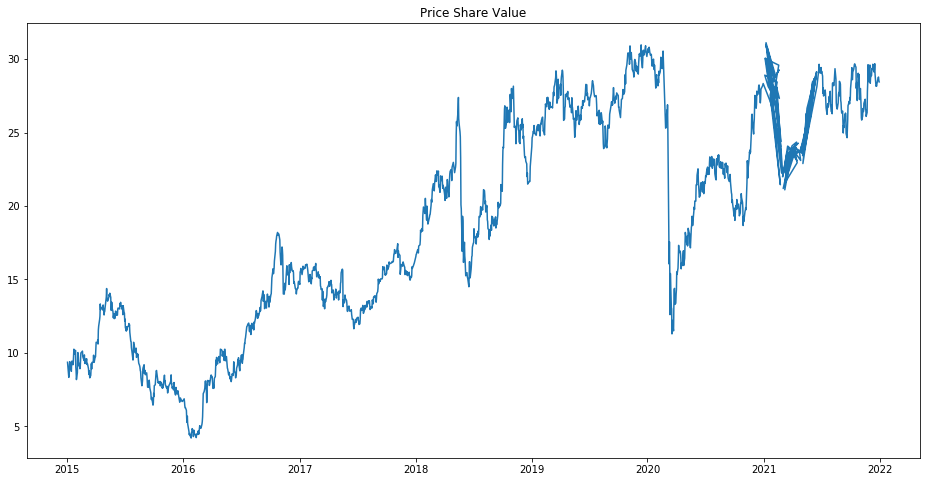

In [226]:
plt.figure(figsize=(16,8))
plt.title('Price Share Value')
plt.plot(df_petro_cls['preco_fechamento'])
#plt.plot(df_petro['data_pregao'])
plt.plot(df_forecast['preco_fechamento'])
plt.legend(['Price Closed', 'Price Predicted'])
plt.show()

In [157]:
df_petro_cls.dtypes

preco_fechamento    float64
dtype: object

In [ ]:
sns.lineplot(data=flights, x="year", y="passengers", hue="month")

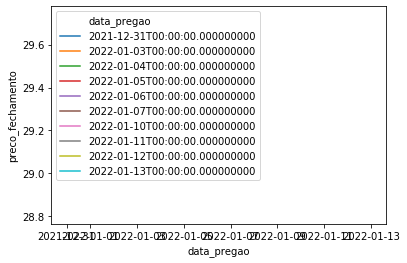

In [227]:
sns.lineplot(data=df_forecast[df_forecast['data_pregao'] > '2021-01-01'], x="data_pregao", y="preco_fechamento", hue="data_pregao")

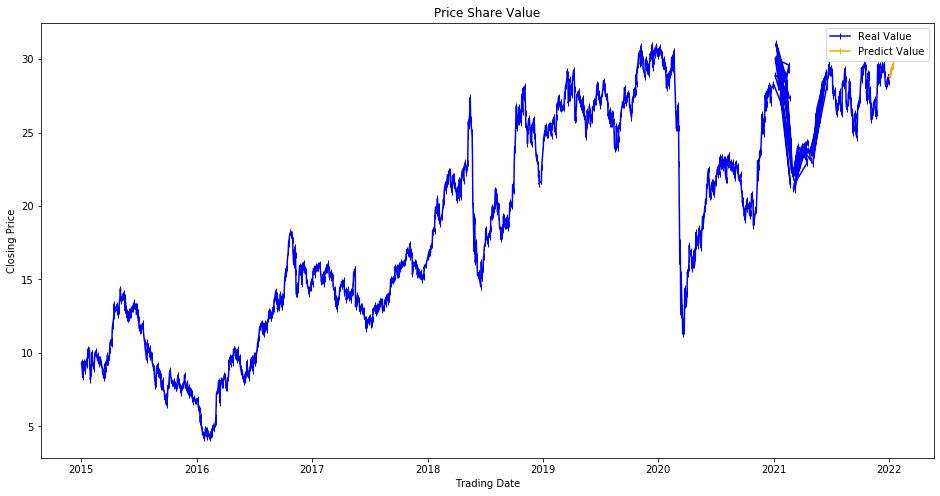

In [228]:
plt.figure(figsize=(16,8))
plt.title('Price Share Value')
plt.plot(df_petro_cls['preco_fechamento'], label='Real Value', color='blue', marker='|');
plt.plot(df_forecast['preco_fechamento'], label='Predict Value', color='orange', marker='|');
plt.xlabel('Trading Date');
plt.ylabel('Closing Price');
leg = plt.legend()


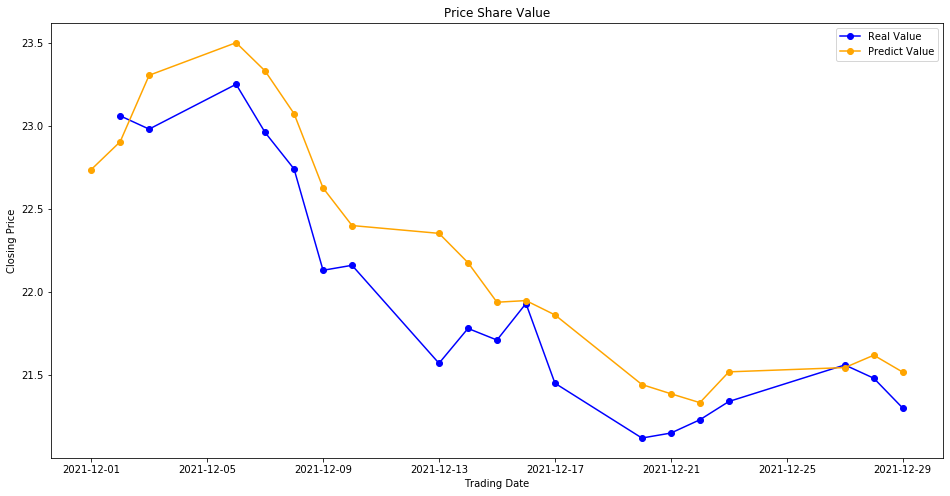

In [49]:
plt.figure(figsize=(16,8))
plt.title('Price Share Value')
plt.plot(df_pred['real'], label='Real Value', color='blue', marker='o');
plt.plot(df_pred['predict'], label='Predict Value', color='orange', marker='o');
plt.xlabel('Trading Date');
plt.ylabel('Closing Price');
leg = plt.legend()


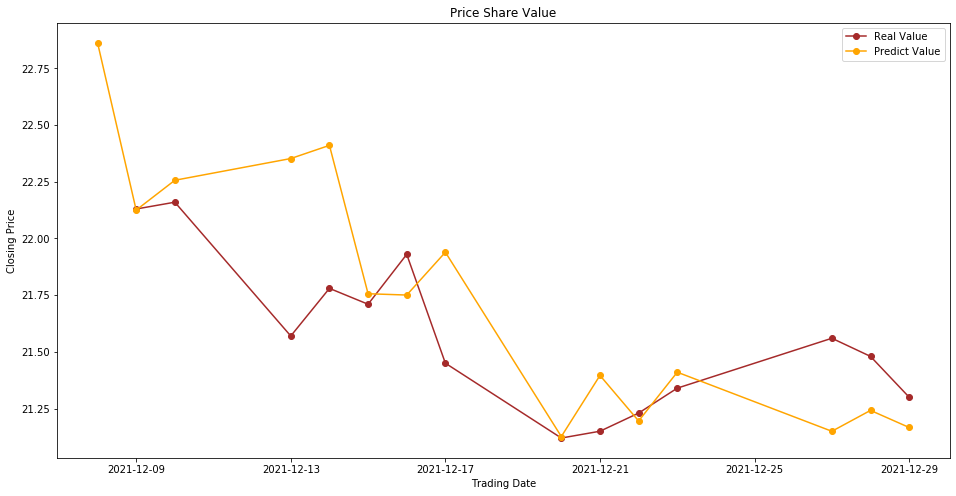

In [99]:
#plt.figure(figsize=(16,8))
#plt.title('Price Share Value')
#plt.plot(df_pred['real'], label='Real Value', color='brown', marker='o');
#plt.plot(df_pred['predict'], label='Predict Value', color='orange', marker='o');
#plt.xlabel('Trading Date');
#plt.ylabel('Closing Price');
#leg = plt.legend()
